# Rapport d'étude de Segment Anything + Stable Diffusion - Tom LE BER (22308482) & Tony PEROTTINO (22303877)

## I. Installation des bibliothèques

### 1. Télécharger NLF

#### A. Cloner le repo NLF (`https://github.com/isarandi/nlf.git`)

In [1]:
import os

# Cloner le repo NLF dans /content (repository officiel) :
if not os.path.exists("/content/nlf"):
    %cd /content
    !git clone https://github.com/isarandi/nlf.git

/content
Cloning into 'nlf'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (304/304), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 304 (delta 139), reused 237 (delta 82), pack-reused 0 (from 0)
Receiving objects: 100% (304/304), 403.72 KiB | 11.21 MiB/s, done.
Resolving deltas: 100% (139/139), done.


#### B. Téléchargement du `TorchScript` associé

In [2]:
%cd /content/nlf

# Créer le dossier pour le modèle et télécharger le TorchScript :
!mkdir -p models
!wget -q -O models/nlf_l_multi.torchscript https://bit.ly/nlf_l_pt # Le lien pointe vers le modèle TorchScript NLF-L publié dans les releases du repo.

/content/nlf


### 2. Télécharger `Segment Anything (V2)`

In [3]:
import sys

REPO_DIR = "/content/sam2_repo"

%cd /content
!rm -rf "{REPO_DIR}" 2>/dev/null
!git clone https://github.com/facebookresearch/sam2.git "{REPO_DIR}"

!{sys.executable} -m pip uninstall -y SAM-2 sam-2 sam2 2>/dev/null
!{sys.executable} -m pip install -e "{REPO_DIR}" --config-settings editable_mode=compat

/content
Cloning into '/content/sam2_repo'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 31.31 MiB/s, done.
Resolving deltas: 100% (381/381), done.
Obtaining file:///content/sam2_repo
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.4 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=12397 sha256=40aa84cc96e784c81b39218629a8e651115a307b70d472e2bbcfb6e111a08011
  Stored in directory: /tmp/pip-ephem-wheel-cache-al8x6eov

### 3. Télécharger `Stable Diffusion`

...

In [4]:
...

Ellipsis

### 4. Vérification de l'environnement

In [5]:
import torch, torchvision

print(f"torch = {torch.__version__}")
print(f"torchvision = {torchvision.__version__}")
print(f"cuda = {torch.cuda.is_available()}")
print(f"torch cuda = {torch.version.cuda}")

torch = 2.9.0+cu126
torchvision = 0.24.0+cu126
cuda = True
torch cuda = 12.6


## II. Chargement des données et import des bibliothèques

### 1. Montage du Google Drive et extraction des images

#### A. Montage du Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### B. Définition des chemins

In [7]:
BASE_DIRECTORY = "/content/drive/MyDrive/02 - Cours/01 - MIDL/Stage MIDL" # A remplacer par le chemin vers le dossier de votre Google Drive contenant la vidéo "video.mp4" et de dossier "frames" contenant toutes les frames de la vidéo.
VIDEO_PATH = os.path.join(BASE_DIRECTORY, "video.mp4")
FRAMES_DIRECTORY = os.path.join(BASE_DIRECTORY, "frames")

# Créer le dossier "frames", s'il n'existe pas déjà :
os.makedirs(FRAMES_DIRECTORY, exist_ok=True)

#### C. Extraction toutes les images de la vidéo

In [8]:
# Extraire toutes les frames :
if not (os.path.isdir(FRAMES_DIRECTORY) and os.listdir(FRAMES_DIRECTORY)):
    !ffmpeg -i "{VIDEO_PATH}" "{FRAMES_DIRECTORY}/frame_%04d.png"

### 2. Import de `NLF`

Dans cette partie, nous appliquons le modèle NLF à la vidéo de pole-dance.  
L’objectif est de :
1. Charger le modèle NLF (version TorchScript) sur GPU.
2. Définir une fonction d’inférence sur une image unique (frame).
3. Appliquer NLF à un sous-ensemble de frames de la vidéo.
4. Visualiser et analyser qualitativement les prédictions (joints 2D et 3D).

Ensuite, chargeons la version TorchScript du modèle NLF (`nlf_l_multi.torchscript`), qui a été téléchargée dans le dossier `/content/nlf/models/` depuis les Releases du dépôt GitHub.

#### A. Initialisation des paramètres

In [9]:
import glob
import numpy as np

# Paramètres d'expérience pour NLF :
MAX_FRAMES = 5000 # Nombre maximum de frames à traiter (pour l'étude).
FRAME_STEP = 165 # 1 = toutes les frames, 2 = une frame sur deux, etc.

# FRAMES_DIRECTORY et BASE_DIRECTORY sont supposés définis dans la partie précédente :
frame_paths_all = sorted(glob.glob(os.path.join(FRAMES_DIRECTORY, "frame_*.png")))

# Sous-échantillonnage éventuel :
frame_paths = frame_paths_all[::FRAME_STEP]

# Limitation au nombre maximum de frames :
frame_paths = frame_paths[:MAX_FRAMES]

print(f"Nombre total de frames extraites : {len(frame_paths_all)}")
print(f"Nombre de frames utilisées pour NLF : {len(frame_paths)}")

Nombre total de frames extraites : 1329
Nombre de frames utilisées pour NLF : 9


#### B. Chargement du modèle

In [10]:
%cd /content/nlf

import torch
import torchvision
from tqdm.auto import tqdm

# Sélection du "device" :
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

# Chemin vers le modèle TorchScript (doit déjà avoir été téléchargé) :
MODEL_PATH = "models/nlf_l_multi.torchscript"

# Chargement du modèle :
model = torch.jit.load(MODEL_PATH, map_location=device).eval()

print("Modèle NLF chargé avec succès.")

/content/nlf
Device utilisé : cuda
Modèle NLF chargé avec succès.


### 3. Import de `Segment Anything (V2)`

In [11]:
import sys
REPO_DIR = "/content/sam2_repo"

# Optionnel (pour tester) :
if REPO_DIR not in sys.path:
    sys.path.insert(0, REPO_DIR)
sys.modules.pop("sam2", None)

# Test des imports :
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.sam2_video_predictor import SAM2VideoPredictor
print(f"Imports de SAM 2 fonctionnels.") # Si on n'a pas le print, c'est qu'on a eu une erreur avant.

Imports de SAM 2 fonctionnels.


### 4. Import de `Stable Diffusion`

...

In [12]:
...

Ellipsis

## III. Exécution de `NLF`

### 1. Détection d'une personne dans une frame donnée

Nous définissons une fonction `run_nlf_on_image(img_path)` qui :
1. Charge une image de frame depuis son chemin.
2. La met au bon format pour NLF (batch de taille 1).
3. Appelle `model.detect_smpl_batched(...)`.
4. Récupère les joints 2D et 3D pour **la première personne** détectée.
5. Retourne un dictionnaire Python sérialisable (listes plutôt que tenseurs).

Nous considérons qu’il n’y a qu’une seule personne (la pole-danseuse) dans la scène.

In [13]:
def run_nlf_on_image(img_path: str):
    """
    Applique NLF à une image unique.
    Retourne un dictionnaire contenant :
      - frame : nom de fichier de la frame,
      - has_person : booléen indiquant si une personne a été détectée,
      - joints2d : liste [J, 2] des coordonnées 2D des joints (en pixels),
      - joints3d : liste [J, 3] des coordonnées 3D des joints (repère caméra).
    """
    # Charger l'image (C,H,W), uint8 :
    image = torchvision.io.read_image(img_path).to(device)

    # Ajouter la dimension batch : [1, C, H, W]
    frame_batch = image.unsqueeze(0)

    # Inférence NLF :
    with torch.inference_mode():
        pred = model.detect_smpl_batched(frame_batch)

    # pred["joints2d"] et pred["joints3d"] sont des listes (une entrée par élément du batch) :
    joints2d_batch = pred["joints2d"][0]
    joints3d_batch = pred["joints3d"][0]

    # Si le modèle renvoie [num_persons, J, 2] ou [num_persons, J, 3] :
    if joints2d_batch.ndim == 3:
        # Si aucune personne détectée :
        if joints2d_batch.shape[0] == 0:
            return {
                "frame": os.path.basename(img_path),
                "has_person": False,
                "joints2d": None,
                "joints3d": None,
            }
        # On prend la première personne :
        j2d = joints2d_batch[0] # [J, 2]
        j3d = joints3d_batch[0] # [J, 3]
    else:
        # Cas où le modèle renvoie directement [J, 2] / [J, 3] :
        j2d = joints2d_batch
        j3d = joints3d_batch

    # Conversion en numpy, puis en listes Python :
    j2d_np = j2d.detach().cpu().numpy()
    j3d_np = j3d.detach().cpu().numpy()

    result = {
        "frame": os.path.basename(img_path),
        "has_person": True,
        "joints2d": j2d_np.tolist(), # [J, 2]
        "joints3d": j3d_np.tolist(), # [J, 3]
    }
    return result

### 2. Inférence sur un lot de frames

Nous appliquons maintenant `run_nlf_on_image` à un sous-ensemble de frames :
- Les chemins de frames sont définis dans la cellule de paramètres (`frame_paths`).
- Nous mesurons le **temps d'inférence** par frame.
- Nous stockons les résultats dans une liste `results`, chaque entrée correspondant à une frame.

À la fin, nous sauvegardons les résultats dans un fichier JSON situé dans `BASE_DIRECTORY`.

In [14]:
import time
import json

results = []
times = []

print(f"Lancement de NLF sur {len(frame_paths)} frames.")

for img_path in tqdm(frame_paths, desc="NLF inference"):
    t0 = time.perf_counter()
    res = run_nlf_on_image(img_path)
    t1 = time.perf_counter()

    res["infer_time"] = t1 - t0 # Temps pour cette frame.
    results.append(res)
    times.append(t1 - t0)

times = np.array(times)

print(f"Nombre total de résultats : {len(results)}")
print(f"Temps moyen par frame : {times.mean()*1000:.1f} ms")
print(f"FPS approximatif : {1.0 / times.mean():.2f}")

# Sauvegarde des résultats dans un JSON :
output_path = os.path.join(BASE_DIRECTORY, "nlf_results_subset.json")
with open(output_path, "w") as f:
    json.dump(results, f)

print(f"Résultats sauvegardés dans : {output_path}")

Lancement de NLF sur 9 frames.


NLF inference:   0%|          | 0/9 [00:00<?, ?it/s]

Nombre total de résultats : 9
Temps moyen par frame : 3961.5 ms
FPS approximatif : 0.25
Résultats sauvegardés dans : /content/drive/MyDrive/02 - Cours/01 - MIDL/Stage MIDL/nlf_results_subset.json


### 3. Visualisation qualitative de NLF

Nous proposons plusieurs visualisations :
1. **Overlay 2D des joints sur une frame** (qualité instantanée de la pose).
2. **Mosaïque de plusieurs frames** avec leurs joints 2D.
3. **Évolution temporelle de la profondeur (Z) d’un joint donné**.
4. **Visualisation 3D d’une pose** à partir de `joints3d`.

Ces visualisations serviront de base à l’analyse qualitative de NLF dans la section suivante.

#### A. Overlay 2D sur une frame

Frames avec personne détectée : 9


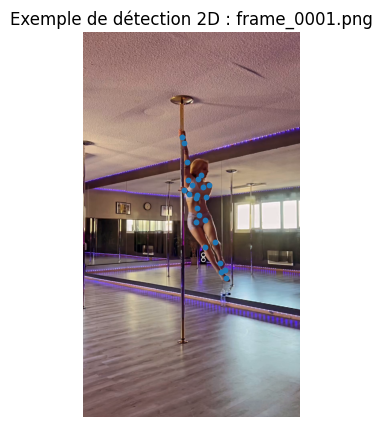

In [15]:
import matplotlib.pyplot as plt

# Filtrer uniquement les frames où une personne a été détectée :
valid_results = [r for r in results if r["has_person"]]

print(f"Frames avec personne détectée : {len(valid_results)}")

if len(valid_results) == 0:
    raise ValueError("Aucune personne détectée dans les frames sélectionnées.")

# On prend un exemple (par ex. la première) :
sample = valid_results[0]
frame_name = sample["frame"]
j2d = np.array(sample["joints2d"]) # [J, 2]

img_path = os.path.join(FRAMES_DIRECTORY, frame_name)
img = torchvision.io.read_image(img_path).permute(1, 2, 0).cpu().numpy() # [H,W,C]

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.scatter(j2d[:, 0], j2d[:, 1], s=10)
plt.title(f"Exemple de détection 2D : {frame_name}")
plt.axis("off")
plt.show()

#### B. Mosaïque de plusieurs frames avec joints 2D

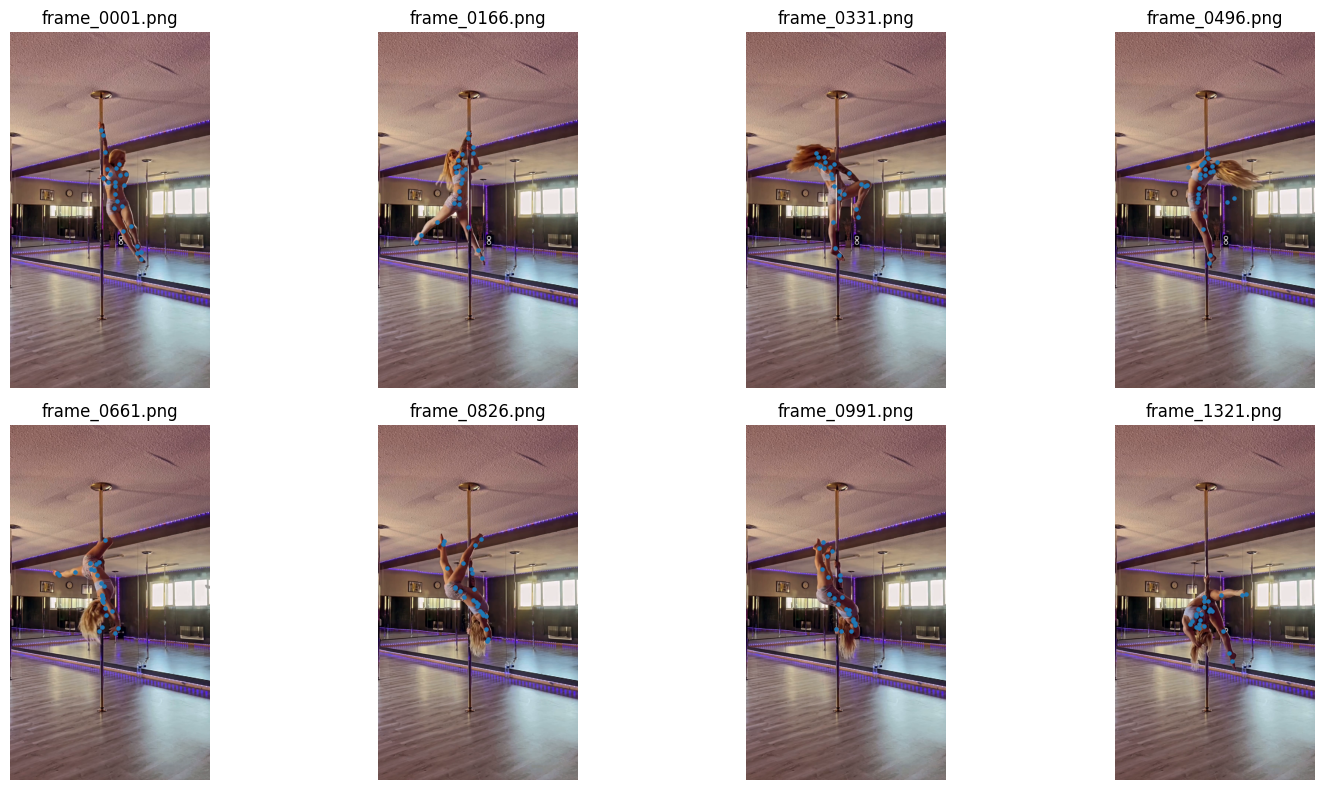

In [16]:
# Nombre d'exemples à afficher dans la mosaïque :
num_examples = min(8, len(valid_results))

# On prend des indices uniformément répartis dans la séquence des frames :
indices = np.linspace(0, len(valid_results) - 1, num_examples, dtype=int)

cols = 4
rows = int(np.ceil(num_examples / cols))

plt.figure(figsize=(4 * cols, 4 * rows))

for i, idx in enumerate(indices, start=1):
    res = valid_results[idx]
    frame_name = res["frame"]
    j2d = np.array(res["joints2d"])

    img_path = os.path.join(FRAMES_DIRECTORY, frame_name)
    img = torchvision.io.read_image(img_path).permute(1, 2, 0).cpu().numpy()

    ax = plt.subplot(rows, cols, i)
    ax.imshow(img)
    ax.scatter(j2d[:, 0], j2d[:, 1], s=5)
    ax.set_title(frame_name)
    ax.axis("off")

plt.tight_layout()
plt.show()

#### C. Évolution de la profondeur Z d’un joint

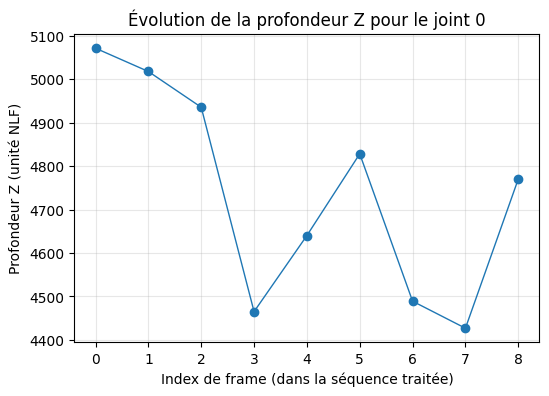

In [17]:
# Indice du joint étudié :
JOINT_INDEX = 0 # 0 = tête.

z_vals = []
frames_idx = []

for i, res in enumerate(results):
    if not res["has_person"]:
        continue
    j3d = np.array(res["joints3d"]) # [J, 3]
    if j3d.shape[0] <= JOINT_INDEX:
        continue
    z_vals.append(j3d[JOINT_INDEX, 2])
    frames_idx.append(i)

plt.figure(figsize=(6, 4))
plt.plot(frames_idx, z_vals, marker="o", linestyle="-", linewidth=1)
plt.xlabel("Index de frame (dans la séquence traitée)")
plt.ylabel("Profondeur Z (unité NLF)")
plt.title(f"Évolution de la profondeur Z pour le joint {JOINT_INDEX}")
plt.grid(True, alpha=0.3)
plt.show()

#### D. Visualisation 3D d’une pose

Frames avec personne détectée : 9


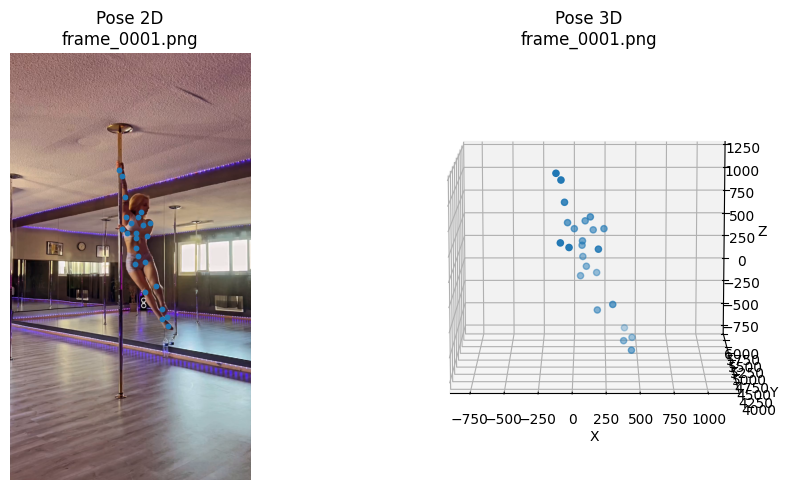

In [18]:
from mpl_toolkits.mplot3d import Axes3D  # Affichage 3D.

# On vérifie qu'on a bien des résultats valides :
valid_results = [r for r in results if r["has_person"]]
print(f"Frames avec personne détectée : {len(valid_results)}")

if len(valid_results) == 0:
    raise ValueError("Aucune personne détectée dans les frames sélectionnées.")

# Choix de l'index de frame à visualiser :
FRAME_INDEX_FOR_3D_VIEW = 0

sample = valid_results[FRAME_INDEX_FOR_3D_VIEW]
frame_name = sample["frame"]
j2d = np.array(sample["joints2d"]) # [J, 2]
j3d = np.array(sample["joints3d"]) # [J, 3]

# Chargement de l'image correspondante :
img_path = os.path.join(FRAMES_DIRECTORY, frame_name)
img = torchvision.io.read_image(img_path).permute(1, 2, 0).cpu().numpy() # [H,W,C]

# Remapping des axes pour que la pose 3D "colle" mieux à l'image :
    # X_vis : gauche/droite
    # Y_vis : profondeur (distance caméra)
    # Z_vis : hauteur (haut/bas) -> on prend -Y pour que le haut soit "vers le haut"
X_vis = j3d[:, 0]
Y_vis = j3d[:, 2]
Z_vis = -j3d[:, 1]

# Petite fonction pour avoir des axes isotropes (squelette non écrasé) :
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range]) / 2.0

    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    ax.set_xlim3d([mid_x - max_range, mid_x + max_range])
    ax.set_ylim3d([mid_y - max_range, mid_y + max_range])
    ax.set_zlim3d([mid_z - max_range, mid_z + max_range])

# Affichage des figures combinées en 2 colonnes :
fig = plt.figure(figsize=(10, 5))
    # Figure 1 (image + joints 2D) :
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img)
ax1.scatter(j2d[:, 0], j2d[:, 1], s=10)
ax1.set_title(f"Pose 2D\n{frame_name}")
ax1.axis("off")
    # Figure 2 (visualisation 3D) :
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.scatter(X_vis, Y_vis, Z_vis)
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")
ax2.set_title(f"Pose 3D\n{frame_name}")
ax2.view_init(elev=10, azim=-90) # Vue "de face" pour que ça ressemble à la projection de l'image.
ax2.grid(True, alpha=0.3) # Grille moins prononcée.
set_axes_equal(ax2)

plt.tight_layout()
plt.show()

## IV. Exécution de `Segment Anything (V2)`

... *(Création de calques **qualitatifs** de la danseuse.)*

In [19]:
...

Ellipsis

Image de test: /content/drive/MyDrive/02 - Cours/01 - MIDL/Stage MIDL/frames/frame_0001.png
BBox depuis NLF: [ 468.37456055  454.69119873  731.77338867 1297.54720459]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sam2.1_hiera_base_plus.pt:   0%|          | 0.00/324M [00:00<?, ?B/s]

scores: [0.96484375 0.8515625  0.95703125] best: 0.96484375
Cutout écrit: /content/sam2_test_cutout.png


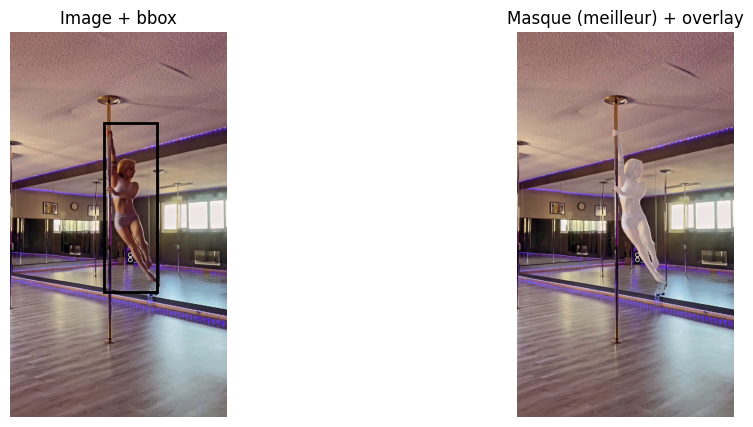

In [20]:
import cv2

# --- Test SAM2 sur UNE frame (bbox -> masque) ---
MODEL_ID = "facebook/sam2.1-hiera-base-plus"  # bon compromis vitesse/qualité (checkpoints SAM2.1)
# (tu peux mettre "...-large" si tu veux plus quali, mais plus lourd)

import glob, os

# 1) choisir une image
if "FRAMES_DIRECTORY" in globals():
    candidates = sorted(glob.glob(os.path.join(FRAMES_DIRECTORY, "*.png")) + glob.glob(os.path.join(FRAMES_DIRECTORY, "*.jpg")))
else:
    candidates = sorted(glob.glob("/content/*.png") + glob.glob("/content/*.jpg"))

assert len(candidates) > 0, "Aucune image trouvée. Vérifie FRAMES_DIRECTORY ou mets une image dans /content."
test_img_path = candidates[0]
print("Image de test:", test_img_path)

bgr = cv2.imread(test_img_path)
assert bgr is not None, "Impossible de lire l'image."
img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
H, W = img.shape[:2]

# 2) bbox depuis NLF si possible, sinon fallback
bbox = None
if "run_nlf_on_image" in globals():
    try:
        pred = run_nlf_on_image(test_img_path)
        pts = np.array(pred.get("joints2d", []), dtype=float)
        if pts.ndim == 2 and pts.shape[0] > 0 and pts.shape[1] == 2:
            x1, y1 = pts.min(axis=0)
            x2, y2 = pts.max(axis=0)
            pad = 0.10
            bw, bh = (x2 - x1), (y2 - y1)
            bbox = np.array([x1 - pad*bw, y1 - pad*bh, x2 + pad*bw, y2 + pad*bh], dtype=float)
            print("BBox depuis NLF:", bbox)
    except Exception as e:
        print("NLF bbox fallback:", repr(e))

if bbox is None:
    bbox = np.array([0.25*W, 0.10*H, 0.75*W, 0.90*H], dtype=float)
    print("BBox fallback (centrée):", bbox)

bbox[0] = np.clip(bbox[0], 0, W-1)
bbox[2] = np.clip(bbox[2], 0, W-1)
bbox[1] = np.clip(bbox[1], 0, H-1)
bbox[3] = np.clip(bbox[3], 0, H-1)

# 3) SAM2 predictor
predictor = SAM2ImagePredictor.from_pretrained(MODEL_ID)
device = "cuda" if torch.cuda.is_available() else "cpu"
predictor.model.to(device)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16, enabled=torch.cuda.is_available()):
    predictor.set_image(img)
    masks, scores, _ = predictor.predict(box=bbox, multimask_output=True)  # bbox XYXY en pixels

best_idx = int(np.argmax(scores))
best_mask = masks[best_idx].astype(bool)
print("scores:", scores, "best:", scores[best_idx])

# 4) export calque RGBA
rgba = np.dstack([img, (best_mask.astype(np.uint8) * 255)])
out_path = "/content/sam2_test_cutout.png"
cv2.imwrite(out_path, cv2.cvtColor(rgba, cv2.COLOR_RGBA2BGRA))
print("Cutout écrit:", out_path)

# 5) visu
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Image + bbox")
plt.imshow(img)
x1,y1,x2,y2 = bbox
plt.gca().add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Masque (meilleur) + overlay")
overlay = img.copy()
overlay[best_mask] = (0.5*overlay[best_mask] + 0.5*np.array([255,255,255])).astype(np.uint8)
plt.imshow(overlay)
plt.axis("off")
plt.show()

## V. Exécution de `Stable Diffusion`

... *(Ré-insertion **qualitative** de la danseuse dans un nouvel environnement.)*

In [21]:
...

Ellipsis

## VI. Conclusion

...